# Vehicle Detection and Tracking
Detect vehicles and track their position on the road in a test video using python, state vector machines, and openCV2
## Author: Aneeq Mahmood
### Email: aneeq.sdc@gmail.com

# Cell 0: Import main modules

In [1]:
# import modules to be used 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
print("Import finished")

Import finished


In [2]:
for val in range(11):
    if ( not val % 5 ):
        print("yes")
    else:
        print('NO')

yes
NO
NO
NO
NO
yes
NO
NO
NO
NO
yes


## Cell 1: Helper to read images from directories

In [3]:
from random import shuffle
def dataset_read( v_dir, nv_dir,veh, nveh):
    """
    Function to read images of vehicles and non-vehicles, and saving them in a dictionary
    Inputs
    v_dir: directory path for vehicle images
    nv_dir: directory path to non-vehicles images
    veh: sub folders  list for vehicles
    nveh: list containing subfolders for non-vehicle images
    
    Output
    image_dic: dictionary of vehicles and non-vehicle images
    """
    image_dic = {}
    key1 = "vehicles"
    key2 = "non_vehicles"
    image_dic[key1] = list()
    image_dic[key2] = list()
    downsample = 5                   # downsample by this number for timeseries  images
    
     # First read non-vehicle images
    for non_vehicles in nveh:
        #iterate through non-vehicles subdirectories  
        img_mask = nv_dir + non_vehicles +'*.png'
        img_names = glob(img_mask)
        
        for img in img_names:           # read images from glob an save in dict
            
            im = cv2.imread(img)        # use cv2 to read so that image values are between 0 and 255
            image_dic[key2].append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))   # change colorspace and save in images
    
    # Iterating through vehicles subfolders    
    for vehicles in veh:
        #iterate through non-vehicles subdirectories  
        img_mask = v_dir + vehicles +'*.png'
        img_names = glob(img_mask)
    
        for ind, img in enumerate(img_names):     # read images from glob an save in dict
            
            if ( "KTTI" in vehicles ):             # Read all images rom KTTI
                im = cv2.imread(img)               # use cv2 to read so that image values are between 0 and 255
                image_dic[key1].append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))   # change colorspace and save in images
            else:                                  # read every 5th image  for GTT
                if (not ind % downsample):
                     im = cv2.imread(img)       
                     image_dic[key1].append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))  

    # Making sure that dictionary keys have same length of values                

    differ = abs(len(image_dic["vehicles"] ) - len(image_dic["non_vehicles"] ))

    # non-vehicles has bigger size 
    temp = image_dic["non_vehicles"]

    shuffle(temp)

    temp[:differ] = []


    image_dic["non_vehicles"] = temp
    
    
    
    return image_dic
    
    

# Cell 1a: Import training dataset

In [4]:
import os

import pickle

# IF images are already sorted and available, then use them
if os.path.exists("image_dict.p"):
    print("Using images already provided in a dictionary")
    with open('image_dict.p', 'rb') as fp:
        image_dict = pickle.load(fp)
    
else: # read images from directory "image_bank"
    print("Making new image dictionary")
    
    #Specifying folders and subfolders for entire data set
    vehicles_dir = "image_bank/vehicles/"
    n_vehicles_dir = "image_bank/non-vehicles/"
    vehicles = ["GTI_Far/","GTI_Left/","GTI_MiddleClose/","GTI_Right/", "KITTI_extracted/"]
    non_vehicles = ["Extras/","GTI/"] 
    
    image_dict = {}
    image_dict = dataset_read(vehicles_dir, n_vehicles_dir, vehicles, non_vehicles)
    

    with open('image_dict.p', 'wb') as fp:
        pickle.dump(image_dict, fp)
    
print("Total vehicles images read are", len(image_dict["vehicles"]), "Size of each image is ", np.shape(image_dict["vehicles"][-1]))
print("Total non-vehicles images read are", len(image_dict["non_vehicles"]), "Size of each image is ", np.shape(image_dict["non_vehicles"][-1]) )
  
#     plt.figure()
#     plt.imshow(im)       
#     plt.show()
    

Using images already provided in a dictionary
Total vehicles images read are 1760 Size of each image is  (64, 64, 3)
Total non-vehicles images read are 1760 Size of each image is  (64, 64, 3)


# Extract Feature Pipeline

In [37]:
from skimage.feature import hog
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features




def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features







def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features



def single_img_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
   
    features = []   
    for img in imgs:

        img_features = []
        spatial_features = []
        hist_features = []
        hogg = []
        #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            
            #print("spatial shape",np.shape(spatial_features))
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            
            #6) Append features to list
            
            #print("hist shape ",np.shape(hist_features))
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
               # hogg = []  
                for channel in range(feature_image.shape[2]):
                    hogg.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hogg = np.ravel(hogg)  
            else:
                hogg.append( get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            #8) Append features to list
            #print("hogg shape ",np.shape(hogg))
            
            img_features.append(np.concatenate((spatial_features,hist_features,hogg)))
           # print("final shape ",np.shape(img_features))

    #9) Return concatenated array of features
    
            features.append(img_features)
 
    return features










def single_img_features1(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)




In [38]:
car_images = image_dict["vehicles"] + image_dict["non_vehicles"]
labels =    np.hstack((np.ones(len(image_dict["vehicles"])), np.zeros(len(image_dict["vehicles"]))))

print(len(labels), np.shape(car_images))



3520 (3520, 64, 64, 3)


In [39]:
color_space = "HLS" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


In [40]:
features = single_img_features(car_images, color_space, 
                            spatial_size, hist_bins, 
                            orient, pix_per_cell, 
                            cell_per_block, 
                            hog_channel,
                             spatial_feat, hist_feat, hog_feat)

sh = np.shape(features)

X = np.reshape(features,(sh[0],sh[2])).astype(np.float64)
print(X.shape)
del features

(3520, 8556)


(3520, 8556)


In [41]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import  grid_search

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)


rand_state = np.random.randint(0, 100)

X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, labels, test_size=0.2, random_state=rand_state)

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = SVC()
# clf = grid_search.GridSearchCV(svr, parameters)




# Out[311]:
# [mean: 0.98260, std: 0.00265, params: {'C': 1, 'kernel': 'linear'},
#  mean: 0.98295, std: 0.00528, params: {'C': 1, 'kernel': 'rbf'},
#  mean: 0.98260, std: 0.00265, params: {'C': 10, 'kernel': 'linear'},
#  mean: 0.98366, std: 0.00401, params: {'C': 10, 'kernel': 'rbf'}]



#Build out classifier
clf=SVC(C = 10, kernel='rbf')


t = time.time()

clf.fit(X_train,Y_train)

t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
#predict 
pred=clf.predict(X_test)

#accuaracy score
acc=accuracy_score(pred,Y_test)
print(acc) #returns 1.0

26.77 Seconds to train SVC...
0.991477272727


In [ ]:
with open('model.p', 'wb') as fp:
        pickle.dump(clf, fp)

In [ ]:

with open('model.p', 'rb') as fp:
        clf = pickle.load(fp)
        
        


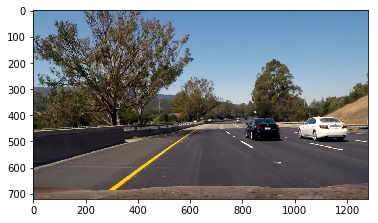

In [12]:
test_dir = "test_images/"

mask = test_dir + '*.jpg'
img_names = glob(mask)                   # Collect image names   

test_images = []
for fn in img_names:

    img = cv2.imread(fn)
    test_images.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))   # change colorspace and save in images

plt.imshow(test_images[-1])
plt.show()

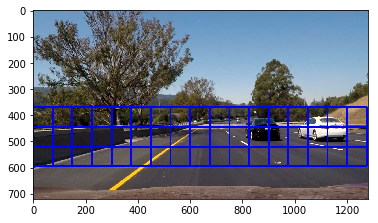

In [30]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


windows = slide_window(test_images[0], x_start_stop=[None, None], y_start_stop=[370,660], 
                    xy_window=(150,150),xy_overlap=(0.5, 0.5))
  
window_img = draw_boxes(test_images[5], windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()


In [31]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features1(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    

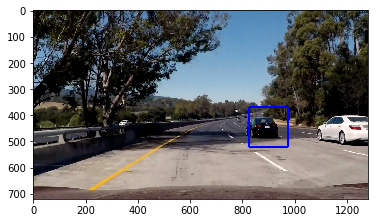

In [42]:
draw_image = np.copy(test_images[4])
hot_windows = search_windows(draw_image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

In [16]:


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

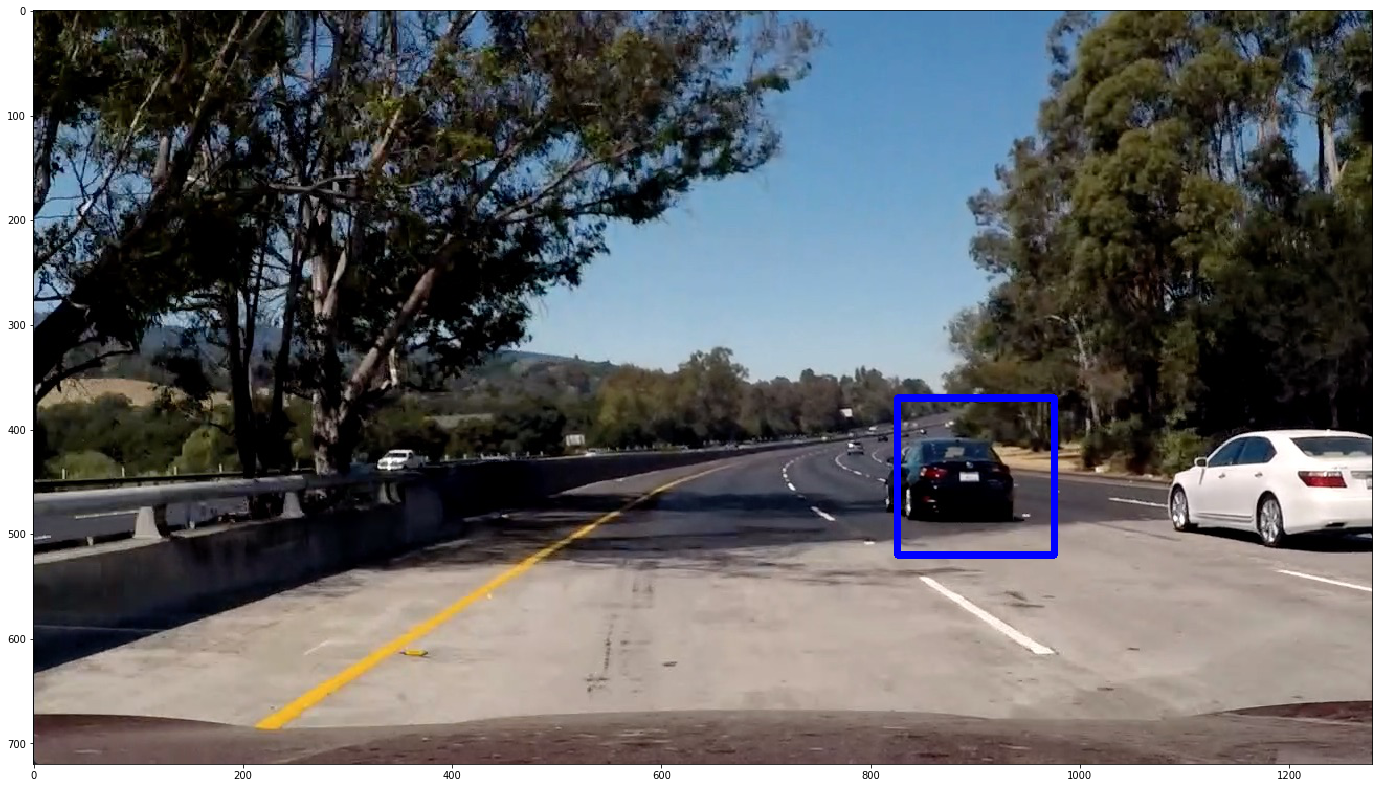

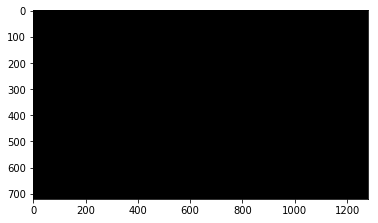

In [43]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
box_list = hot_windows
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
raw_img = draw_labeled_bboxes(np.copy(draw_image), labels)
plt.figure(figsize=(24,16))
plt.imshow(window_img)
plt.figure()
plt.imshow(heatmap,cmap="gray")


plt.show()
